---
# Построение модели для выявления токсичных комментариев

---

<u>**Цель проекта**</u>: Построение модели для выявления токсичных комментариев;

<u>**Сферы деятельности компаний**</u>: Интернет-сервисы, социальные сети, мессенджеры

<u>**Навыки и инструменты**</u>: Токенизация, лемматизация, SpaCy, NLTK, градиентиный бустинг.

<a name="оглавление"></a>
## Оглавление:
#### 1. [Подготовка](#подготовка)
#### 2. [Обучение](#обучение)
#### 3. [Выводы](#выводы)

<a name="подготовка"></a>
# 1. Подготовка

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install spacy

In [3]:
# %load imports.py
#Основные библиотеки
import pandas as pd
import numpy as np
import math as m
import scipy
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

import ipyparallel as ipp

from pymystem3 import Mystem
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import torch
import transformers

#Параметры визуализации
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #закомментировать в случае возникновения проблем :)
rcParams['figure.figsize'] = 12, 10
sns.set(rc={'figure.figsize':(14, 10)})

#Параметры отображения результатов выполнения кода в ячейках
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from ipywidgets import widgets
from IPython.display import display, clear_output

#Параметры предупреждений
import warnings
warnings.simplefilter('ignore')

#tqdm
from tqdm.notebook import tqdm

#time
import time 
import datetime

#ML
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, GridSearchCV,
                                     KFold, cross_val_score)

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  PassiveAggressiveClassifier, Perceptron)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import (accuracy_score, r2_score, f1_score, mean_squared_error,
                             mean_absolute_error, precision_score, recall_score,
                             precision_recall_curve, plot_precision_recall_curve,
                             confusion_matrix, roc_curve, roc_auc_score, make_scorer,
                             average_precision_score)

from sklearn.dummy import DummyClassifier

import joblib

C:\Users\Boris\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Boris\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Boris\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Boris\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [4]:
import lightgbm as lgb
import spacy
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.utils import resample

Загрузим CSV-файл и изучим данные:

In [5]:
data_toxic_comments_0 = pd.read_csv(...)

In [6]:
data_toxic_comments_0

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


Класса два: одни комментарии токсичны, другие — нет. Перед нами задача бинарной классификации. Посмотрим, в каком соотношении представлены классы:

In [7]:
data_toxic_comments_0.query('toxic == 1')
len(data_toxic_comments_0.query('toxic == 1'))/len(data_toxic_comments_0.query('toxic == 0'))

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...
159494,"""\n\n our previous conversation \n\nyou fuckin...",1
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159541,Your absurd edits \n\nYour absurd edits on gre...,1
159546,"""\n\nHey listen don't you ever!!!! Delete my e...",1


0.1131876717871444

Соотношение приближается к 1:10, а это уже говорит о том, что модели необходимо обучать на сбалансированных выборках.

Подготовим данные. Так как мы сильно ограничены в ресурсах (в частности, в доступном объёме оперативной памяти), Natural Language Toolkit — не лучший вариант. Будем использовать SpaCy:

In [8]:
#Список со знаками препинания
punctuations = string.punctuation

#Список со стоп-словами
spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#Слова, содержащиеся в комментариях, английские
parser = English()

#Токенизатор
def spacy_tokenizer(sentence):
    
    mytokens = parser(sentence)

    #Лемматизация, приведение к нижнему регистру
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]

    #Очистка от стоп-слов
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]

    return mytokens

def clean_text(text):

    return text.strip().lower()

#Трансформер
class predictors(TransformerMixin):
    def transform(self, features, **transform_params):
        
        return [clean_text(text) for text in features]

    def fit(self, features, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [9]:
bow_vector = CountVectorizer(tokenizer=spacy_tokenizer)
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

Разделим датасет на обучающую и тестовую выборки:

In [10]:
data_train, data_test = train_test_split(data_toxic_comments_0, test_size=0.1)

Изучим дисбаланс классов:

In [11]:
data_train.toxic.value_counts()

data_train_majority = data_train[data_train.toxic==0]
data_train_minority = data_train[data_train.toxic==1]

0    129037
1     14576
Name: toxic, dtype: int64

Сбалансируем классы апсемплингом:

In [12]:
data_train_minority_upsampled = resample(data_train_minority, 
                                         replace=True,
                                         n_samples=129036,
                                         random_state=12345)
 
data_train_upsampled = pd.concat([data_train_majority, data_train_minority_upsampled])
 
data_train_upsampled.toxic.value_counts()

0    129037
1    129036
Name: toxic, dtype: int64

Выделим целевой признак:

In [13]:
features_train = data_train_upsampled['text']

target_train = data_train_upsampled['toxic']

features_test = data_test['text']

target_test = data_test['toxic']

#### [К оглавлению](#оглавление)

<a name="обучение"></a>
# 2. Обучение

Создадим датафрейм, в который будем отправлять модели и значения метрик:

In [14]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

Обучим логистическую регрессию. Соберём пайплайн, осуществляющий последовательно очистку и векторизацию текста, а затем обучение выбранной модели с заданными гиперпараметрами:

In [15]:
%%time

classifier_lr = LogisticRegression(#class_weight='balanced',
#                                    solver='saga',
#                                    max_iter=200,
#                                    multi_class='ovr',
                                   n_jobs=-1)

# Create pipeline using Bag of Words
pipe_lr = Pipeline([("cleaner", predictors()),
                    ('vectorizer', bow_vector),
                    ('classifier', classifier_lr)])

# model generation
pipe_lr.fit(features_train, target_train)

predicted_lr = pipe_lr.predict(features_test)

print("Accuracy:", accuracy_score(target_test, predicted_lr))
print("Precision:", precision_score(target_test, predicted_lr))
print("Recall:", recall_score(target_test, predicted_lr))
print("F1:", f1_score(target_test, predicted_lr))

Accuracy: 0.9450432385010653
Precision: 0.7077502691065662
Recall: 0.7974530018192845
F1: 0.7499287140005703
Wall time: 13min 47s


In [16]:
results.loc[0] = ['LogisticRegression',
                  accuracy_score(target_test, predicted_lr),
                  precision_score(target_test, predicted_lr),
                  recall_score(target_test, predicted_lr),
                  f1_score(target_test, predicted_lr)]
results

,Model,Accuracy,Precision,Recall,F1
0,LogisticRegression,0.945043,0.70775,0.797453,0.749929


Обучим классификатор LightGBM, зададим тип бустинга — Gradient Boosting Decision Tree. Задача — "бинарная классификация". Будем передавать каждой базовой модели четверть всех признаков.
В цикле будем подбирать число базовых моделей и максимальную глубину дерева. Число листьев свяжем с максимальной глубиной степенной зависимостью:

In [17]:
lgbmc_results = pd.DataFrame()

In [18]:
%%time
# for n_estimators in tqdm(range(1, 2001, 100)):
#     for max_depth in range(1, 6):
for n_estimators in tqdm(range(1800, 1801)):
    for max_depth in range(5, 6):
        num_leaves = 2**(max_depth-1)+1
        classifier_lgb = lgb.LGBMClassifier(boosting_type='gbdt',
                                            num_leaves=num_leaves,
                                            max_depth=max_depth,
                                            n_estimators=n_estimators,
                                            objective='binary',
                                            class_weight='balanced',
        #                                     colsample_bytree=1,
                                            random_state=12345,
                                            n_jobs=-1,
                                            silent=False)

        pipe_lgb = Pipeline([("cleaner", predictors()),
                         ('vectorizer', tfidf_vector),
                         ('classifier', classifier_lgb)])

        pipe_lgb.fit(features_train, target_train)

        predicted_lgb = pipe_lgb.predict(features_test)

        print("Parameters: n_estimators={}, max_depth={}, num_leaves={}".format(n_estimators,
                                                                                max_depth,
                                                                                num_leaves))
        print("Accuracy:", accuracy_score(target_test, predicted_lgb))
        print("Precision:", precision_score(target_test, predicted_lgb))
        print("Recall:", recall_score(target_test, predicted_lgb))
        print("F1:", f1_score(target_test, predicted_lgb))
        print()
        print()
        print()
        lgbmc_results = lgbmc_results.append([[n_estimators,
                                                max_depth,
                                                num_leaves,
                                                f1_score(target_test, predicted_lgb),
                                                accuracy_score(target_test, predicted_lgb),
                                                precision_score(target_test, predicted_lgb),
                                                recall_score(target_test, predicted_lgb)]])
lgbmc_results.columns = ['n_estimators',
                          'max_depth',
                          'num_leaves',
                          'f1',
                          'accuracy',
                          'precision',
                          'recall']
lgbmc_results

Parameters: n_estimators=1800, max_depth=5, num_leaves=17
Accuracy: 0.9483017922045369
Precision: 0.7234273318872018
Recall: 0.8089751364463311
F1: 0.7638133409676495




Wall time: 26min 23s


,n_estimators,max_depth,num_leaves,f1,accuracy,precision,recall
0,1800,5,17,0.763813,0.948302,0.723427,0.808975


In [19]:
results.loc[1] = ['LGBMClassifier',
                  accuracy_score(target_test, predicted_lgb),
                  precision_score(target_test, predicted_lgb),
                  recall_score(target_test, predicted_lgb),
                  f1_score(target_test, predicted_lgb)]
results

,Model,Accuracy,Precision,Recall,F1
0,LogisticRegression,0.945043,0.707750,0.797453,0.749929
1,LGBMClassifier,0.948302,0.723427,0.808975,0.763813


Обучим KNeighboursClassifier, сравним с другими моделями:

In [20]:
%%time

classifier_kn = KNeighborsClassifier(n_jobs=-1)


pipe_kn = Pipeline([("cleaner", predictors()),
                    ('vectorizer', bow_vector),
                    ('classifier', classifier_kn)])

pipe_kn.fit(features_train, target_train)

predicted_kn = pipe_kn.predict(features_test)

print("Accuracy:", accuracy_score(target_test, predicted_kn))
print("Precision:", precision_score(target_test, predicted_kn))
print("Recall:", recall_score(target_test, predicted_kn))
print("F1:", f1_score(target_test, predicted_kn))

Accuracy: 0.8853866399298158
Precision: 0.45557749259624875
Recall: 0.5597331716191631
F1: 0.502312925170068
Wall time: 13min 39s


In [21]:
results.loc[2] = ['KNeighborsClassifier',
                  accuracy_score(target_test, predicted_kn),
                  precision_score(target_test, predicted_kn),
                  recall_score(target_test, predicted_kn),
                  f1_score(target_test, predicted_kn)]
results

,Model,Accuracy,Precision,Recall,F1
0,LogisticRegression,0.945043,0.707750,0.797453,0.749929
1,LGBMClassifier,0.948302,0.723427,0.808975,0.763813
2,KNeighborsClassifier,0.885387,0.455577,0.559733,0.502313


В качестве финальной модели выберем **логистическую регрессию**:

In [22]:
model_final = pipe_lr.fit(features_train, target_train)

Построим PR-кривую:


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.82')

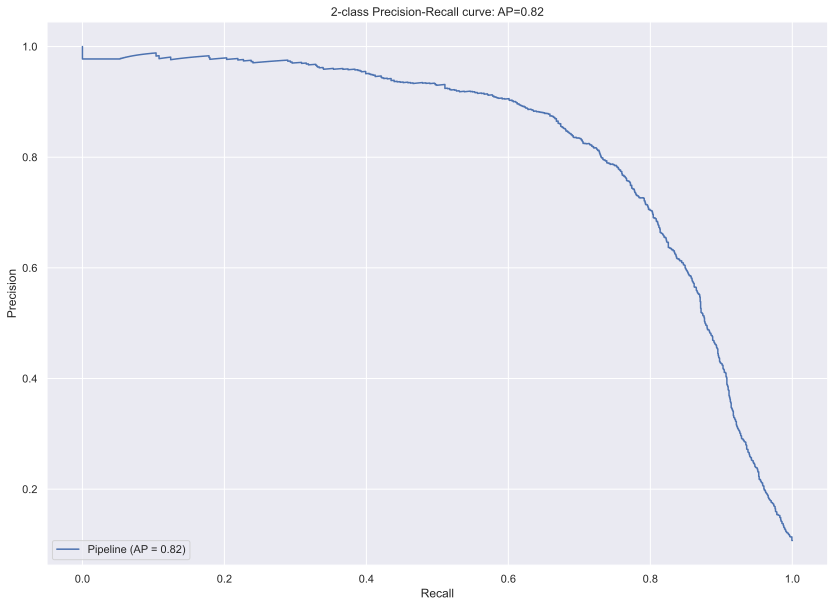

In [23]:
probabilities_test = model_final.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
average_precision = average_precision_score(target_test, probabilities_one_test)
disp = plot_precision_recall_curve(model_final, features_test, target_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

Посмотрим на **кривую ошибок**:

<Figure size 648x648 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-кривая')

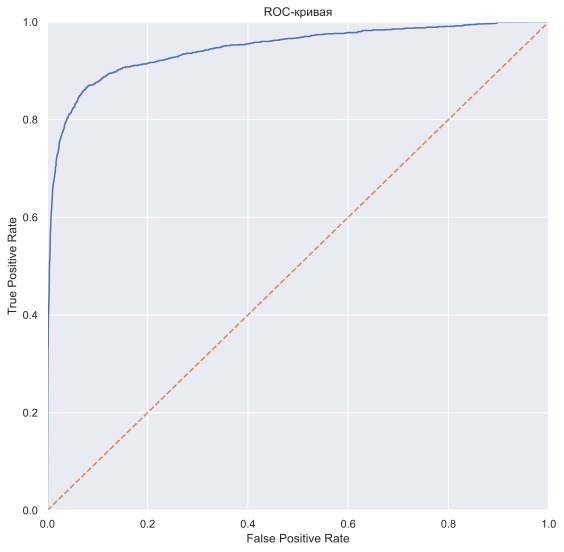

AUC-ROC:  0.9458898187585527


In [24]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(9, 9))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('AUC-ROC: ', auc_roc)

#### [К оглавлению](#оглавление)

<a name="выводы"></a>
# 3. Выводы

<div style="border: solid darkcyan 3px; padding: 30px">
<h3 style="color:black; margin-bottom:25px"> Общие выводы: </h3>
    <ul>
    <li><b>Загружен и изучен датасет</b>;</li>
    <li><b>Подготовлены инструменты для очистки, токенизации, лемматизации и векторизации текстов</b>;</li>
    <li><b>Изучен баланс классов, доля минорного класса увеличена апсемплингом</b>;</li>
    <li><b>Обучены линейная регрессия, логистическая регрессия и классификатор из библиотеки LightGBM</b>;</li>
    <li><b>В качестве финальной модели выбрана логистическая регрессия, получены значения метрики F1 > 0.75, изучены кривая ошибок и AUC-ROC</b>.</li>
    </ul>
</div>

#### [К оглавлению](#оглавление)